chebyshev.ipynb was getting too big, so we're starting a new one

In [1]:
import sys
from sympy import init_session
init_session()
from mpmath import mpf
%matplotlib inline

IPython console for SymPy 1.0.1.dev (Python 3.5.2-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/dev



Now we try to mechanise the CRAM process

In [2]:
def bisect_roots(expr, bounds, eps=1e-7, division_cutoff=30, solver='bisect', **kwargs):
    """
    Numerically find all the roots of expr in bounds via bisection
    
    division_cutoff is the fraction of bounds to check for roots. 
    One should expect the roots to be no more than |bounds|/division_cutoff apart.
    """
    roots = []
    intervals = [bounds]
    var = expr.free_symbols.pop()
    N = 0
    while intervals:
        N += 1
        #print(intervals)
        b = intervals.pop()
        try:
            root = nsolve(expr, b, solver=solver, **kwargs)
        except ValueError:
            # No root found
            if (b[1] - b[0]) > (bounds[1] - bounds[0])/division_cutoff and sign(expr.evalf(subs={var: b[0]})) == sign(expr.evalf(subs={var: b[1]})):
                # The bisect method will only work if the interval has alternate signs.
                # If not, it will miss 2 roots, so try again with split intervals.
                intervals.append([b[0], (b[0] + b[1])/2])
                intervals.append([(b[0] + b[1])/2, b[1]])
                continue
        else:
            if root not in roots:
                roots.append(root)
                intervals.append([b[0], root - eps])
                intervals.append([root + eps, b[1]])
    
    print(N)
    return sorted(roots)

bisect_roots(sin(x), [-10, 13])

115


In [3]:
def nsolve_intervals(expr, bounds, division=30, warn=False, verbose=False, solver='bisect', **kwargs):
    """
    Divide bounds into division intervals and nsolve in each one
    """
    if verbose:
        warn = True
    roots = []
    L = bounds[1] - bounds[0]
    for i in range(division):
        interval = [bounds[0] + i*L/division, bounds[0] + (i + 1)*L/division]
        try:
            if verbose:
                print("Solving in interval", interval)
            root = nsolve(expr, interval, solver=solver, **kwargs)
        except ValueError:
            if verbose:
                print("No solution found")
            continue
        else:
            if interval[0] < root < interval[1]:
                if verbose:
                    print("Solution found:", root)
                roots.append(root)
            else:
                if warn:
                    print(root, "is not in", interval, 'discarding', file=sys.stderr)
            
    return roots
        
#nsolve_intervals(D, [-1, 0.99])

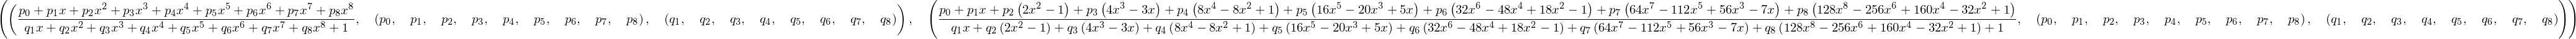

In [4]:
def general_rat_func(d, x, chebyshev=False):
    """
    Return a general rational function with numerator and denominator degree d
    
    Returns a tuple, (rational function, numerator coefficients, denominator coefficients)
    
    The constant coefficient in the denominator is always 1.
    """
    num_coeffs = symbols('p:%s' % (d+1))
    den_coeffs = symbols('q:%s' % (d+1))[1:]
    if chebyshev:
        num = Add(*(Mul(c, chebyshevt(i, x)) for i, c in enumerate(num_coeffs)))
        den = Add(*(Mul(c, chebyshevt(i, x)) for i, c in enumerate([1, *den_coeffs])))
        rat_func = num/den
    else:
        rat_func = Poly(reversed(num_coeffs), x)/Poly([*reversed(den_coeffs), 1], x)
    return rat_func, num_coeffs, den_coeffs

general_rat_func(8, x), general_rat_func(8, x, chebyshev=True)

--------------------------------------------------------------------------------
Iteration 0:
sol {q8: 0.0054633852294689777309166007423756238454556199526015652010405250510581099695633239650090366853608704727843764773768234888487373309283918577008428346540749975474652190883778258719780982141925809943552048052599208317227055204660999484641571356777025790939639161659476600084032172357742887963201722470405018994396809237650377430775914460800767378218009923640484187693451876810685848194970984137915348365163837445778601976580670931743317702702731877279622306318012786020503305946506200266972642348644791225965351679466526189753018538321350468639747608138141228560588957118619685190460311317663898733865683163174163253998052574066625479003254907913152431148444352840913100396668575180173218907772387620307315883183095642305286544775691014558665903246847007996235367393998576447899636211803013730744272826683646286598012419241112098437593611695638503510685602762468212459328517669442202208856855882682

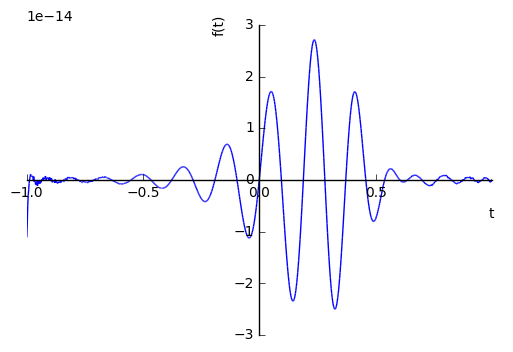

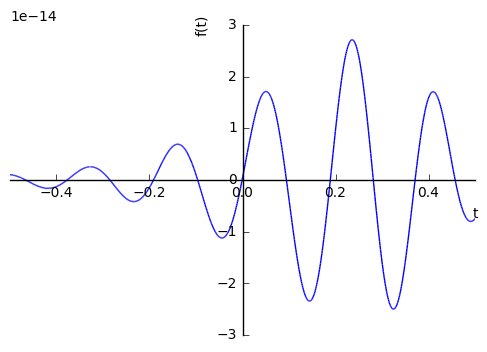

-(-0.00111002261919918758393632571568104822462631276423425766911996194901585296719614440043225695527971177845006453730162143676606556341778651406690414245861274200351516148419298113425796959841694663241118801346515395502064587681683004740846329875150695036623814971617534918610558508979526181243652235138451223581492528812824510926899049071277393663706480272214817336525255959236260321021012343687595320003914693806626360177665167204513813746375632986884539379941027782385309087891843639027869036441055156075945222498579275625818229958802249098780621816298479720861841783608278254151828940609730546702472032938712938173312700495352418838838020047800521004601509218645251370302256735257094560621873318247286973569228033504998116219827497389201098821352780421550183130724421487606203335241405117006267016584546702536259609511157714651074721056222269033125423980360865510084800488805327198076407023370812152699216384759292586893837719194593556386388669504934070433996319922167184414328935757613671795605

AssertionError: 16

In [5]:
from sympy.utilities.decorator import conserve_mpmath_dps

@conserve_mpmath_dps
def CRAM_exp2(degree, prec=128, *, max_loops=10):
    #mpmath.mp.dps = prec


    epsilon = symbols("epsilon")
    i = symbols("i")
    #c = S(1)/2
    #c = 10
    c = degree*0.6
    
    r, num_coeffs, den_coeffs = general_rat_func(degree, t, chebyshev=True)
    E = exp(c*(t + 1)/(t - 1)) - r
    expr = E + (-1)**i*epsilon
    expr = expr*r.as_numer_denom()[1]
    expr = simplify(expr)

    points = [chebyshevt_root(2*(degree + 1) + 1, 2*(degree + 1) - j) for j in range(1, 2*(degree + 1) + 1)]
    points = [i.evalf(prec) for i in points]
    for iteration in range(max_loops):
        print('-'*80)
        print("Iteration %s:" % iteration)
        system = Tuple(*[expr.subs({i: j, t: points[j]}) for j in range(2*degree + 1)])
        system = system + Tuple(expr.replace(exp, lambda i: 0).subs({i: 2*degree + 1, t: 1}))
        #print(system)
        #print([*num_coeffs, *den_coeffs, epsilon])
        sol = dict(zip([*num_coeffs, *den_coeffs, epsilon], nsolve(system, [*num_coeffs, *den_coeffs, epsilon], [*[1]*(2*(degree + 1) - 1), 0], prec=prec)))
        print('sol', sol)
        print('system.subs(sol)', [i.evalf() for i in system.subs(sol)])
        D = diff(E.subs(sol), t)
        plot(E.subs(sol), (t, -1, 0.999), adaptive=False, nb_of_points=1000)
        plot(E.subs(sol), (t, -0.5, 0.5), adaptive=False, nb_of_points=1000)
        #plot(E.subs(sol), (t, 0.9, 1))
        # we can't use 1 because of the singularity
        print(E.subs(sol))
        points = [-1, *nsolve_intervals(D, [-1, 0.999999], maxsteps=10000, prec=prec, division=200, warn=True, tol=10**-(2*prec)), 1]
        #points2 = [-1, *nsolve_intervals(D, [-1, 0.999999], maxsteps=300, prec=prec, solver='illinois', verify=True), 1]
        #print('points', points)
        #print('points2', points2)
        print('D', D)
        print('[(i, D.subs(t, i)) for i in points]', [(i, D.subs(t, i)) for i in points])
        assert len(points) == 2*(degree + 1), len(points)
        Evals = [E.evalf(prec, subs={**sol, t: point}) for point in points[:-1]] + [-r.evalf(prec, subs={**sol, t: 1})]
        print('Evals', Evals)
        maxmin = N(max(map(abs, Evals)) - min(map(abs, Evals)))
        print('max - min', maxmin)
        print('epsilon', N(sol[epsilon]))
        if maxmin < 10**-prec:
            print("Converged in", iteration + 1, "iterations.")
            break
    else:
        print("!!!WARNING: DID NOT CONVERGE AFTER", max_loops, "ITERATIONS!!!", file=sys.stderr)
        
    #print(sol)
    #sol = {i: Rational(str(sol[i])) for i in sol}
    #print(sol)
    inv = solve(-c*(t + 1)/(t - 1) - y, t)[0].subs(y, t)
    n, d = together(r.subs(sol).subs(t, inv)).as_numer_denom() # simplify/cancel here will add degree to the numerator and denominator
    rat_func = (Poly(n)/Poly(d).TC())/(Poly(d)/Poly(d).TC())
    return rat_func.evalf(prec)

#D = CRAM_exp2()

rat_func = CRAM_exp2(15, 1000)
print(rat_func)
plot(rat_func - exp(-t), (t, 0, 100))

In [ ]:
!say done

In [ ]:
correct_rat_func2 = (9.92641e-1 + -1.88332e-1*t + 4.21096e-3*t**2)/(1 + 6.69295e-1*t + 5.72258e-1*t**2)
plot(correct_rat_func2 - exp(-t), (t, 0, 100))

In [ ]:
#plot(rat_func - correct_rat_func2, (t, 0, 100))

In [ ]:
plot((correct_rat_func2 - exp(-t))/correct_rat_func2, (t, 20, 100))

In [ ]:
nsolve(D, (-1, -0.39506511254484362 - 1e-20), solver='bisect', tol=1e-20)

In [ ]:
#import mpmath
#mpmath.findroot?

In [ ]:
plot(sin(x), (x, -10, 13))

In [ ]:
nsolve(sin(x), [-10, -0.1], solver='bisect')

In [ ]:
bisect_roots(D, [-1, 0.9], solver='bisect')

In [ ]:
plot(D, (t, -1, 1))

In [ ]:
nsolve(D, [mpf('0.2069106899549174') + 1e-4, 0.999], solver='ridder')

In [ ]:
intervals = [[i/30, (i+1)/30] for i in range(-30, 29)]

In [ ]:
def catch_ValueError(f):
    try:
        return f()
    except ValueError:
        pass

In [ ]:
[catch_ValueError(lambda: nsolve(D, b, solver='bisect')) for b in intervals]

In [ ]:
sin(x).evalf(subs={x: mpf('9.9999999999999995e-8')})

In [ ]:
nsolve(D, (-1, 0), solver='bisect')

In [ ]:
D

In [ ]:
import mpmath
try:
    mpmath.mp.dps = 128
    print(nsolve(D, (-1, 0), solver='bisect', maxsteps=300))
finally:
    mpmath.mp.dps = 15

In [ ]:
chebyshevt(2, x)

In [ ]:
0.9999999999999999

In [ ]:
0.99999999999999999

In [ ]:
exp(-(-t - 1)/(2*t - 2))

In [ ]:
solve((0.57224957904836676579778131095824616229041363386436155632065723326613208320645433529158968043480368460271370103317310738469165646*t**2 + 0.66930154271086975944415360267931286108869186534800442869820775970713699218292282609079303557228276229468949430966691265928683428*t + 1.0))

In [ ]:
[1, 2, 3][:-1]

In [ ]:
plot((t + 1)/(t - 1)*(-1/2), (t, -1, 1))

In [ ]:
solve(y - -(-t - 1)/(2*t - 2), t)

In [ ]:
exp(-(-t - 1)/(2*t - 2)).evalf(subs={t: 0})

In [ ]:
len('42109959068982')

In [ ]:
@conserve_mpmath_dps
def test_increased_dps():
    # Issue 8564
    import mpmath
    mpmath.mp.dps = 128
    x = Symbol('x')
    e1 = x**2 - pi
    q = nsolve(e1, x, 3.0)

    assert abs(sqrt(pi).evalf(128) - q) < 1e-128

test_increased_dps()

In [ ]:
@conserve_mpmath_dps
def test_mpf_subs():
    import mpmath
    mpmath.mp.dps = 128
    a = mpf('1') + mpf('1e-100')
    print(a)
    print(x.subs(x, a))
    print(Float(a))

test_mpf_subs()

In [ ]:
@conserve_mpmath_dps
def test_increased_dps2():
    # Issue 8564
    import mpmath
    mpmath.mp.dps = 128
    x = Symbol('x')
    e1 = x**2 - pi
    q = nsolve(e1, x, 3.0)
    print((x**2).subs(x, q))
    print(pi.evalf(128))

test_increased_dps2()

In [ ]:
p0, p1, p2, q1, q2, epsilon = symbols("p0, p1, p2, q1, q2, epsilon")
r = (p0 + p1*t + p2*t**2)/(1 + q1*t + q2*t**2)
mpf = lambda i: Float(i, 128)
sol = {q1: mpf('-1.1598158896958144389688907541448290768017556418690225475316113676987123000368036156835800708110657203943382445749046292411027838124'), epsilon: mpf('-0.0073586701695804955713909885597251540212160797660122172060482127633180200310633941837926800633336626154349676612971775593725674790502'), p1: mpf('-1.3420582608178928401767377898250826050312440510776128093723998679786607122879166676244905769597498693757444204486264349423147412592'), q2: mpf('0.54706937851182403348832181267224373295821044378627516587652817178767445252898045643900602804552389487580236216086250141313671452195'), p2: mpf('0.73617861351264467252445532341623038921509966014009367227031009417645097851179620934054146565716699654528814524660644163951335402577'), p0: mpf('0.6087293180014645115203537929174427433501475052521283394857491045045741371996335477254671722188240766010031663167379415577767292914')}
other_rat_func ="(0.0042109959068981902319228224147959051043334784348885130731594832554304543920692286150512328715813585751529478908147308247510818304*t**2 - 0.1883335019892743246297189560004799477752569428797900790843481507588522143198473107264222704579544281038255097909548061885535647*t + 0.99264132983041950442860901144027484597878392023398778279395178723668197996893660581620731993666633738456503233870282244062743252)/(0.57224957904836377040707255710162720198078512465710225748045909842276672878045476079146532782980255617241659394936652703249328588*t**2 + 0.66930154271087159949217750010925437712785181665997133501826390508750116474339450131113420220623360917322211168993495402213680723*t + 1.0)"

n, d = together(r.subs(sol).subs(t, (2*t - 1)/(2*t + 1))).as_numer_denom() # simplify/cancel here will add degree to the numerator and denominator
rat_func = (Poly(n)/Poly(d).TC())/(Poly(d)/Poly(d).TC())
print(rat_func)
print(other_rat_func)
del mpf

In [ ]:
import sys
print('test', file=sys.stderr)

In [ ]:
10**-10

In [ ]:
D = (-2*(t + 1)/(2*t - 2)**2 + 1/(2*t - 2))*exp((t + 1)/(2*t - 2)) - (-0.46319625019273218908*t**13 + 11.076239035694458023*t**12 - 75.38527286719552296*t**11 + 242.00660160608425014*t**10 - 389.01043643289017999*t**9 + 165.53549638768474282*t**8 + 538.42392697795239075*t**7 - 1160.0181368287938552*t**6 + 1064.6133061016735644*t**5 - 435.60064981285300771*t**4 - 47.836952574354747137*t**3 + 134.72356135348252232*t**2 - 56.370239030181725748*t + 8.3057523340557002803)*(0.054548679300092563818*t**14 - 1.3501921589697942721*t**13 + 9.0345240868201266233*t**12 - 27.90433797500592764*t**11 + 40.52259728739627843*t**10 - 2.2008514365998888364*t**9 - 97.728246570230795738*t**8 + 181.14960511639832727*t**7 - 159.50642335868838789*t**6 + 56.243320662736403761*t**5 + 26.808952900880779959*t**4 - 41.915371037748377236*t**3 + 21.829567246295711762*t**2 - 5.6442241022971821787*t + 0.6065306597126334236)/(0.033085446442338013506*t**14 - 0.85201838736111215565*t**13 + 6.28210607226629358*t**12 - 22.000600146007659103*t**11 + 38.901043643289017999*t**10 - 18.392832931964971424*t**9 - 67.302990872244048844*t**8 + 165.71687668982769361*t**7 - 177.43555101694559406*t**6 + 87.120129962570601541*t**5 + 11.959238143588686784*t**4 - 44.907853784494174105*t**3 + 28.185119515090862874*t**2 - 8.3057523340557002803*t + 1)**2 - (0.76368151020129589345*t**13 - 17.552498066607325537*t**12 + 108.41428904184151948*t**11 - 306.94771772506520404*t**10 + 405.2259728739627843*t**9 - 19.807662929398999527*t**8 - 781.82597256184636591*t**7 + 1268.0472358147882909*t**6 - 957.03854015213032735*t**5 + 281.2166033136820188*t**4 + 107.23581160352311984*t**3 - 125.74611311324513171*t**2 + 43.659134492591423524*t - 5.6442241022971821787)/(0.033085446442338013506*t**14 - 0.85201838736111215565*t**13 + 6.28210607226629358*t**12 - 22.000600146007659103*t**11 + 38.901043643289017999*t**10 - 18.392832931964971424*t**9 - 67.302990872244048844*t**8 + 165.71687668982769361*t**7 - 177.43555101694559406*t**6 + 87.120129962570601541*t**5 + 11.959238143588686784*t**4 - 44.907853784494174105*t**3 + 28.185119515090862874*t**2 - 8.3057523340557002803*t + 1)

In [ ]:
sols = nsolve_intervals(D, [-1, 0.999999], division=100)
print(sols)
print(len(sols))

In [ ]:
!say done

In [ ]:
[D.subs(t, s) for s in sols]

In [ ]:
E = S("exp((t + 1)/(2*t - 2)) - (0.041232283944696212177*t**14 + 1.3765734756274427394*t**13 - 11.423548266294669551*t**12 + 34.897781468305479785*t**11 - 48.170553853698286848*t**10 + 13.655351758955469199*t**9 + 46.6129883570929947*t**8 - 56.479130360958931409*t**7 + 5.525098125593180923*t**6 + 31.467377104584776578*t**5 - 18.246029053439227394*t**4 - 5.9943769501854388096*t**3 + 10.340721799222326113*t**2 - 4.2100165484624456618*t + 0.6065306597126334236)/(0.025008644382436209356*t**14 + 0.80992537393279613982*t**13 - 7.7761706067212429946*t**12 + 27.673671566138794968*t**11 - 47.057239733847679512*t**10 + 28.109557440827452275*t**9 + 30.919259146443448213*t**8 - 61.83483011093278413*t**7 + 22.957457767970616141*t**6 + 26.975517392632053618*t**5 - 26.389699317234955361*t**4 - 1.0791378811026364212*t**3 + 11.607824151320777869*t**2 - 5.9411438334495710432*t + 1)")

In [ ]:
plot(E, (t, 0.7, 0.8), adaptive=False, nb_of_points=10000)

In [ ]:
chebyshevt(1, 1)

In [ ]:
[*enumerate(['a', 'b', 'c'])]

In [ ]:
system = S("Tuple(-p0 + 0.98846832432811139916*p1 - 0.050649168838712711749*p10 - 0.10116832198743217456*p11 + 0.25065253225872053539*p12 - 0.39435585511331859613*p13 + 0.5289640103269624416*p14 - 0.95413925640004885148*p2 + 0.89780453957074165714*p3 - 0.82076344120727632636*p4 + 0.72479278722911995887*p5 - 0.61210598254766284416*p6 + 0.48530196253108102515*p7 - 0.34730525284482028541*p8 + 0.20129852008866007873*p9 + (epsilon + 0.99710456213012649629)*(-0.98846832432811139916*q1 + 0.050649168838712711749*q10 + 0.10116832198743217456*q11 - 0.25065253225872053539*q12 + 0.39435585511331859613*q13 - 0.5289640103269624416*q14 + 0.95413925640004885148*q2 - 0.89780453957074165714*q3 + 0.82076344120727632636*q4 - 0.72479278722911995887*q5 + 0.61210598254766284416*q6 - 0.48530196253108102515*q7 + 0.34730525284482028541*q8 - 0.20129852008866007873*q9 + 1), -p0 + 0.96807711886620430515*p1 + 0.82076344120727632615*p10 - 0.93775213214708045842*p11 + 0.99486932339189514118*p12 - 0.98846832432811142281*p13 + 0.91895781162023063016*p14 - 0.87434661614458211883*p2 + 0.72479278722911995886*p3 - 0.52896401032696245737*p4 + 0.29936312297335795401*p5 - 0.050649168838712712237*p6 - 0.20129852008866007919*p7 + 0.44039415155763430936*p8 - 0.65137248272222220705*p9 + (-epsilon + 0.99192262841900652865)*(-0.96807711886620430515*q1 - 0.82076344120727632615*q10 + 0.93775213214708045842*q11 - 0.99486932339189514118*q12 + 0.98846832432811142281*q13 - 0.91895781162023063016*q14 + 0.87434661614458211883*q2 - 0.72479278722911995886*q3 + 0.52896401032696245737*q4 - 0.29936312297335795401*q5 + 0.050649168838712712237*q6 + 0.20129852008866007919*q7 - 0.44039415155763430936*q8 + 0.65137248272222220705*q9 + 1), -p0 + 0.93775213214708045843*p1 + 0.91895781162023062755*p10 - 0.72479278722911995726*p11 + 0.44039415155763430437*p12 - 0.10116832198743218276*p13 - 0.2506525322587205562*p14 - 0.75875812269279090192*p2 + 0.48530196253108102522*p3 - 0.15142777750457666366*p4 - 0.20129852008866007914*p5 + 0.52896401032696245735*p6 - 0.79077573693769858208*p7 + 0.95413925640004885141*p8 - 0.99871650717105280743*p9 + (epsilon + 0.98406642835075986461)*(-0.93775213214708045843*q1 - 0.91895781162023062755*q10 + 0.72479278722911995726*q11 - 0.44039415155763430437*q12 + 0.10116832198743218276*q13 + 0.2506525322587205562*q14 + 0.75875812269279090192*q2 - 0.48530196253108102522*q3 + 0.15142777750457666366*q4 + 0.20129852008866007914*q5 - 0.52896401032696245735*q6 + 0.79077573693769858208*q7 - 0.95413925640004885141*q8 + 0.99871650717105280743*q9 + 1), -p0 + 0.89780453957074165714*p1 + 0.15142777750457666382*p10 + 0.29936312297335795208*p11 - 0.68896691907568656868*p12 + 0.93775213214708046506*p13 - 0.99486932339189512731*p14 - 0.61210598254766284415*p2 + 0.20129852008866007914*p3 + 0.25065253225872053932*p4 - 0.65137248272222220746*p5 + 0.91895781162023062913*p6 - 0.99871650717105280713*p7 + 0.87434661614458211861*p8 - 0.57126821509479227908*p9 + (-epsilon + 0.97343458335469763991)*(-0.89780453957074165714*q1 - 0.15142777750457666382*q10 - 0.29936312297335795208*q11 + 0.68896691907568656868*q12 - 0.93775213214708046506*q13 + 0.99486932339189512731*q14 + 0.61210598254766284415*q2 - 0.20129852008866007914*q3 - 0.25065253225872053932*q4 + 0.65137248272222220746*q5 - 0.91895781162023062913*q6 + 0.99871650717105280713*q7 - 0.87434661614458211861*q8 + 0.57126821509479227908*q9 + 1), -p0 + 0.84864425749475095046*p1 - 0.7587581226927909016*p10 + 0.98846832432811139721*p11 - 0.91895781162023063016*p12 + 0.57126821509479228581*p13 - 0.050649168838712711749*p14 - 0.44039415155763430952*p2 - 0.10116832198743217778*p3 + 0.61210598254766284414*p4 - 0.93775213214708045842*p5 + 0.97952994125249449394*p6 - 0.72479278722911995886*p7 + 0.25065253225872053918*p8 + 0.29936312297335795414*p9 + (epsilon + 0.9598896419605118508)*(-0.84864425749475095046*q1 + 0.7587581226927909016*q10 - 0.98846832432811139721*q11 + 0.91895781162023063016*q12 - 0.57126821509479228581*q13 + 0.050649168838712711749*q14 + 0.44039415155763430952*q2 + 0.10116832198743217778*q3 - 0.61210598254766284414*q4 + 0.93775213214708045842*q5 - 0.97952994125249449394*q6 + 0.72479278722911995886*q7 - 0.25065253225872053918*q8 - 0.29936312297335795414*q9 + 1), -p0 + 0.79077573693769858208*p1 - 0.95413925640004885152*p10 + 0.57126821509479227959*p11 + 0.050649168838712713483*p12 - 0.65137248272222220499*p13 + 0.97952994125249449528*p14 - 0.25065253225872053932*p2 - 0.3943558551133185801*p3 + 0.87434661614458211883*p4 - 0.98846832432811139917*p5 + 0.6889669190756865678*p6 - 0.10116832198743217778*p7 - 0.52896401032696245732*p8 + 0.93775213214708045842*p9 + (-epsilon + 0.94325632448977341962)*(-0.79077573693769858208*q1 + 0.95413925640004885152*q10 - 0.57126821509479227959*q11 - 0.050649168838712713483*q12 + 0.65137248272222220499*q13 - 0.97952994125249449528*q14 + 0.25065253225872053932*q2 + 0.3943558551133185801*q3 - 0.87434661614458211883*q4 + 0.98846832432811139917*q5 - 0.6889669190756865678*q6 + 0.10116832198743217778*q7 + 0.52896401032696245732*q8 - 0.93775213214708045842*q9 + 1), -p0 + 0.72479278722911995887*p1 - 0.25065253225872053951*p10 - 0.48530196253108102528*p11 + 0.95413925640004885152*p12 - 0.8978045395707416562*p13 + 0.34730525284482029018*p14 - 0.050649168838712712279*p2 - 0.65137248272222220745*p3 + 0.99486932339189514632*p4 - 0.79077573693769858208*p5 + 0.15142777750457666365*p6 + 0.57126821509479227918*p7 - 0.97952994125249449387*p8 + 0.84864425749475095033*p9 + (epsilon + 0.92331964820666129003)*(-0.72479278722911995887*q1 + 0.25065253225872053951*q10 + 0.48530196253108102528*q11 - 0.95413925640004885152*q12 + 0.8978045395707416562*q13 - 0.34730525284482029018*q14 + 0.050649168838712712279*q2 + 0.65137248272222220745*q3 - 0.99486932339189514632*q4 + 0.79077573693769858208*q5 - 0.15142777750457666365*q6 - 0.57126821509479227918*q7 + 0.97952994125249449387*q8 - 0.84864425749475095033*q9 + 1), -p0 + 0.65137248272222220745*p1 + 0.68896691907568656781*p10 - 0.9987165071710528071*p11 + 0.61210598254766284418*p12 + 0.20129852008866007835*p13 - 0.87434661614458211807*p14 + 0.15142777750457666366*p2 - 0.84864425749475095047*p3 + 0.95413925640004885148*p4 - 0.3943558551133185801*p5 - 0.44039415155763430951*p6 + 0.96807711886620430516*p7 - 0.82076344120727632634*p8 + 0.1011683219874321778*p9 + (-epsilon + 0.89982327219932776296)*(-0.65137248272222220745*q1 - 0.68896691907568656781*q10 + 0.9987165071710528071*q11 - 0.61210598254766284418*q12 - 0.20129852008866007835*q13 + 0.87434661614458211807*q14 - 0.15142777750457666366*q2 + 0.84864425749475095047*q3 - 0.95413925640004885148*q4 + 0.3943558551133185801*q5 + 0.44039415155763430951*q6 - 0.96807711886620430516*q7 + 0.82076344120727632634*q8 - 0.1011683219874321778*q9 + 1), -p0 + 0.57126821509479227916*p1 + 0.97952994125249449398*p10 - 0.39435585511331858023*p11 - 0.52896401032696245754*p12 + 0.99871650717105280716*p13 - 0.61210598254766284397*p14 + 0.34730525284482028554*p2 - 0.96807711886620430515*p3 + 0.75875812269279090191*p4 + 0.10116832198743217779*p5 - 0.87434661614458211882*p6 + 0.89780453957074165714*p7 - 0.15142777750457666369*p8 - 0.72479278722911995884*p9 + (epsilon + 0.8724686291509901109)*(-0.57126821509479227916*q1 - 0.97952994125249449398*q10 + 0.39435585511331858023*q11 + 0.52896401032696245754*q12 - 0.99871650717105280716*q13 + 0.61210598254766284397*q14 - 0.34730525284482028554*q2 + 0.96807711886620430515*q3 - 0.75875812269279090191*q4 - 0.10116832198743217779*q5 + 0.87434661614458211882*q6 - 0.89780453957074165714*q7 + 0.15142777750457666369*q8 + 0.72479278722911995884*q9 + 1), -p0 + 0.48530196253108102521*p1 + 0.34730525284482028554*p10 + 0.65137248272222220744*p11 - 0.97952994125249449395*p12 + 0.29936312297335795411*p13 + 0.68896691907568656803*p14 + 0.52896401032696245737*p2 - 0.99871650717105280715*p3 + 0.44039415155763430952*p4 + 0.57126821509479227916*p5 - 0.99486932339189514632*p6 + 0.3943558551133185801*p7 + 0.61210598254766284416*p8 - 0.98846832432811139917*p9 + (-epsilon + 0.84091577660137237175)*(-0.48530196253108102521*q1 - 0.34730525284482028554*q10 - 0.65137248272222220744*q11 + 0.97952994125249449395*q12 - 0.29936312297335795411*q13 - 0.68896691907568656803*q14 - 0.52896401032696245737*q2 + 0.99871650717105280715*q3 - 0.44039415155763430952*q4 - 0.57126821509479227916*q5 + 0.99486932339189514632*q6 - 0.3943558551133185801*q7 - 0.61210598254766284416*q8 + 0.98846832432811139917*q9 + 1), -p0 + 0.3943558551133185801*p1 - 0.61210598254766284414*p10 + 0.96807711886620430514*p11 - 0.15142777750457666367*p12 - 0.84864425749475095045*p13 + 0.82076344120727632639*p14 + 0.6889669190756865678*p2 - 0.93775213214708045843*p3 + 0.050649168838712712278*p4 + 0.89780453957074165714*p5 - 0.75875812269279090191*p6 - 0.29936312297335795401*p7 + 0.99486932339189514632*p8 - 0.48530196253108102521*p9 + (epsilon + 0.80478747993180621938)*(-0.3943558551133185801*q1 + 0.61210598254766284414*q10 - 0.96807711886620430514*q11 + 0.15142777750457666367*q12 + 0.84864425749475095045*q13 - 0.82076344120727632639*q14 - 0.6889669190756865678*q2 + 0.93775213214708045843*q3 - 0.050649168838712712278*q4 - 0.89780453957074165714*q5 + 0.75875812269279090191*q6 + 0.29936312297335795401*q7 - 0.99486932339189514632*q8 + 0.48530196253108102521*q9 + 1), -p0 + 0.29936312297335795401*p1 - 0.99486932339189514632*p10 + 0.20129852008866007913*p11 + 0.87434661614458211883*p12 - 0.72479278722911995887*p13 - 0.44039415155763430949*p14 + 0.82076344120727632636*p2 - 0.79077573693769858208*p3 - 0.34730525284482028554*p4 + 0.99871650717105280715*p5 - 0.25065253225872053931*p6 - 0.84864425749475095047*p7 + 0.75875812269279090191*p8 + 0.39435585511331858011*p9 + (-epsilon + 0.76367894724544165258)*(-0.29936312297335795401*q1 + 0.99486932339189514632*q10 - 0.20129852008866007913*q11 - 0.87434661614458211883*q12 + 0.72479278722911995887*q13 + 0.44039415155763430949*q14 - 0.82076344120727632636*q2 + 0.79077573693769858208*q3 + 0.34730525284482028554*q4 - 0.99871650717105280715*q5 + 0.25065253225872053931*q6 + 0.84864425749475095047*q7 - 0.75875812269279090191*q8 - 0.39435585511331858011*q9 + 1), -p0 + 0.20129852008866007914*p1 - 0.44039415155763430952*p10 - 0.79077573693769858208*p11 + 0.75875812269279090191*p12 + 0.48530196253108102521*p13 - 0.95413925640004885148*p14 + 0.91895781162023062913*p2 - 0.57126821509479227916*p3 - 0.6889669190756865678*p4 + 0.84864425749475095046*p5 + 0.34730525284482028554*p6 - 0.98846832432811139916*p7 + 0.050649168838712712279*p8 + 0.96807711886620430515*p9 + (epsilon + 0.71717703508602379371)*(-0.20129852008866007914*q1 + 0.44039415155763430952*q10 + 0.79077573693769858208*q11 - 0.75875812269279090191*q12 - 0.48530196253108102521*q13 + 0.95413925640004885148*q14 - 0.91895781162023062913*q2 + 0.57126821509479227916*q3 + 0.6889669190756865678*q4 - 0.84864425749475095046*q5 - 0.34730525284482028554*q6 + 0.98846832432811139916*q7 - 0.050649168838712712279*q8 - 0.96807711886620430515*q9 + 1), -p0 + 0.10116832198743217779*p1 + 0.52896401032696245737*p10 - 0.89780453957074165714*p11 - 0.34730525284482028554*p12 + 0.96807711886620430515*p13 + 0.15142777750457666366*p14 + 0.97952994125249449394*p2 - 0.29936312297335795401*p3 - 0.91895781162023062913*p4 + 0.48530196253108102521*p5 + 0.82076344120727632636*p6 - 0.65137248272222220745*p7 - 0.6889669190756865678*p8 + 0.79077573693769858208*p9 + (-epsilon + 0.66489484531991716168)*(-0.10116832198743217779*q1 - 0.52896401032696245737*q10 + 0.89780453957074165714*q11 + 0.34730525284482028554*q12 - 0.96807711886620430515*q13 - 0.15142777750457666366*q14 - 0.97952994125249449394*q2 + 0.29936312297335795401*q3 + 0.91895781162023062913*q4 - 0.48530196253108102521*q5 - 0.82076344120727632636*q6 + 0.65137248272222220745*q7 + 0.6889669190756865678*q8 - 0.79077573693769858208*q9 + 1), -p0 + p10 - p12 + p14 + p2 - p4 + p6 - p8 + (epsilon + exp(-1/2))*(-q10 + q12 - q14 - q2 + q4 - q6 + q8 + 1), -p0 - 0.10116832198743217779*p1 + 0.52896401032696245737*p10 + 0.89780453957074165714*p11 - 0.34730525284482028554*p12 - 0.96807711886620430515*p13 + 0.15142777750457666366*p14 + 0.97952994125249449394*p2 + 0.29936312297335795401*p3 - 0.91895781162023062913*p4 - 0.48530196253108102521*p5 + 0.82076344120727632636*p6 + 0.65137248272222220745*p7 - 0.6889669190756865678*p8 - 0.79077573693769858208*p9 + (-epsilon + 0.54196418516113069989)*(0.10116832198743217779*q1 - 0.52896401032696245737*q10 - 0.89780453957074165714*q11 + 0.34730525284482028554*q12 + 0.96807711886620430515*q13 - 0.15142777750457666366*q14 - 0.97952994125249449394*q2 - 0.29936312297335795401*q3 + 0.91895781162023062913*q4 + 0.48530196253108102521*q5 - 0.82076344120727632636*q6 - 0.65137248272222220745*q7 + 0.6889669190756865678*q8 + 0.79077573693769858208*q9 + 1), -p0 - 0.20129852008866007914*p1 - 0.44039415155763430952*p10 + 0.79077573693769858208*p11 + 0.75875812269279090191*p12 - 0.48530196253108102521*p13 - 0.95413925640004885148*p14 + 0.91895781162023062913*p2 + 0.57126821509479227916*p3 - 0.6889669190756865678*p4 - 0.84864425749475095046*p5 + 0.34730525284482028554*p6 + 0.98846832432811139916*p7 + 0.050649168838712712279*p8 - 0.96807711886620430515*p9 + (epsilon + 0.47140756707585578791)*(0.20129852008866007914*q1 + 0.44039415155763430952*q10 - 0.79077573693769858208*q11 - 0.75875812269279090191*q12 + 0.48530196253108102521*q13 + 0.95413925640004885148*q14 - 0.91895781162023062913*q2 - 0.57126821509479227916*q3 + 0.6889669190756865678*q4 + 0.84864425749475095046*q5 - 0.34730525284482028554*q6 - 0.98846832432811139916*q7 - 0.050649168838712712279*q8 + 0.96807711886620430515*q9 + 1), -p0 - 0.29936312297335795401*p1 - 0.99486932339189514632*p10 - 0.20129852008866007913*p11 + 0.87434661614458211883*p12 + 0.72479278722911995887*p13 - 0.44039415155763430949*p14 + 0.82076344120727632636*p2 + 0.79077573693769858208*p3 - 0.34730525284482028554*p4 - 0.99871650717105280715*p5 - 0.25065253225872053931*p6 + 0.84864425749475095047*p7 + 0.75875812269279090191*p8 - 0.39435585511331858011*p9 + (-epsilon + 0.39563118171972868313)*(0.29936312297335795401*q1 + 0.99486932339189514632*q10 + 0.20129852008866007913*q11 - 0.87434661614458211883*q12 - 0.72479278722911995887*q13 + 0.44039415155763430949*q14 - 0.82076344120727632636*q2 - 0.79077573693769858208*q3 + 0.34730525284482028554*q4 + 0.99871650717105280715*q5 + 0.25065253225872053931*q6 - 0.84864425749475095047*q7 - 0.75875812269279090191*q8 + 0.39435585511331858011*q9 + 1), -p0 - 0.3943558551133185801*p1 - 0.61210598254766284414*p10 - 0.96807711886620430514*p11 - 0.15142777750457666367*p12 + 0.84864425749475095045*p13 + 0.82076344120727632639*p14 + 0.6889669190756865678*p2 + 0.93775213214708045843*p3 + 0.050649168838712712278*p4 - 0.89780453957074165714*p5 - 0.75875812269279090191*p6 + 0.29936312297335795401*p7 + 0.99486932339189514632*p8 + 0.48530196253108102521*p9 + (epsilon + 0.3162777185489854716)*(0.3943558551133185801*q1 + 0.61210598254766284414*q10 + 0.96807711886620430514*q11 + 0.15142777750457666367*q12 - 0.84864425749475095045*q13 - 0.82076344120727632639*q14 - 0.6889669190756865678*q2 - 0.93775213214708045843*q3 - 0.050649168838712712278*q4 + 0.89780453957074165714*q5 + 0.75875812269279090191*q6 - 0.29936312297335795401*q7 - 0.99486932339189514632*q8 - 0.48530196253108102521*q9 + 1), -p0 - 0.48530196253108102521*p1 + 0.34730525284482028554*p10 - 0.65137248272222220744*p11 - 0.97952994125249449395*p12 - 0.29936312297335795411*p13 + 0.68896691907568656803*p14 + 0.52896401032696245737*p2 + 0.99871650717105280715*p3 + 0.44039415155763430952*p4 - 0.57126821509479227916*p5 - 0.99486932339189514632*p6 - 0.3943558551133185801*p7 + 0.61210598254766284416*p8 + 0.98846832432811139917*p9 + (-epsilon + 0.23624479246104157387)*(0.48530196253108102521*q1 - 0.34730525284482028554*q10 + 0.65137248272222220744*q11 + 0.97952994125249449395*q12 + 0.29936312297335795411*q13 - 0.68896691907568656803*q14 - 0.52896401032696245737*q2 - 0.99871650717105280715*q3 - 0.44039415155763430952*q4 + 0.57126821509479227916*q5 + 0.99486932339189514632*q6 + 0.3943558551133185801*q7 - 0.61210598254766284416*q8 - 0.98846832432811139917*q9 + 1), -p0 - 0.57126821509479227916*p1 + 0.97952994125249449398*p10 + 0.39435585511331858023*p11 - 0.52896401032696245754*p12 - 0.99871650717105280716*p13 - 0.61210598254766284397*p14 + 0.34730525284482028554*p2 + 0.96807711886620430515*p3 + 0.75875812269279090191*p4 - 0.10116832198743217779*p5 - 0.87434661614458211882*p6 - 0.89780453957074165714*p7 - 0.15142777750457666369*p8 + 0.72479278722911995884*p9 + (epsilon + 0.1600193379721607684)*(0.57126821509479227916*q1 - 0.97952994125249449398*q10 - 0.39435585511331858023*q11 + 0.52896401032696245754*q12 + 0.99871650717105280716*q13 + 0.61210598254766284397*q14 - 0.34730525284482028554*q2 - 0.96807711886620430515*q3 - 0.75875812269279090191*q4 + 0.10116832198743217779*q5 + 0.87434661614458211882*q6 + 0.89780453957074165714*q7 + 0.15142777750457666369*q8 - 0.72479278722911995884*q9 + 1), -p0 - 0.65137248272222220745*p1 + 0.68896691907568656781*p10 + 0.9987165071710528071*p11 + 0.61210598254766284418*p12 - 0.20129852008866007835*p13 - 0.87434661614458211807*p14 + 0.15142777750457666366*p2 + 0.84864425749475095047*p3 + 0.95413925640004885148*p4 + 0.3943558551133185801*p5 - 0.44039415155763430951*p6 - 0.96807711886620430516*p7 - 0.82076344120727632634*p8 - 0.1011683219874321778*p9 + (-epsilon + 0.093631266675993090694)*(0.65137248272222220745*q1 - 0.68896691907568656781*q10 - 0.9987165071710528071*q11 - 0.61210598254766284418*q12 + 0.20129852008866007835*q13 + 0.87434661614458211807*q14 - 0.15142777750457666366*q2 - 0.84864425749475095047*q3 - 0.95413925640004885148*q4 - 0.3943558551133185801*q5 + 0.44039415155763430951*q6 + 0.96807711886620430516*q7 + 0.82076344120727632634*q8 + 0.1011683219874321778*q9 + 1), -p0 - 0.72479278722911995887*p1 - 0.25065253225872053951*p10 + 0.48530196253108102528*p11 + 0.95413925640004885152*p12 + 0.8978045395707416562*p13 + 0.34730525284482029018*p14 - 0.050649168838712712279*p2 + 0.65137248272222220745*p3 + 0.99486932339189514632*p4 + 0.79077573693769858208*p5 + 0.15142777750457666365*p6 - 0.57126821509479227918*p7 - 0.97952994125249449387*p8 - 0.84864425749475095033*p9 + (epsilon + 0.0435595768207820696)*(0.72479278722911995887*q1 + 0.25065253225872053951*q10 - 0.48530196253108102528*q11 - 0.95413925640004885152*q12 - 0.8978045395707416562*q13 - 0.34730525284482029018*q14 + 0.050649168838712712279*q2 - 0.65137248272222220745*q3 - 0.99486932339189514632*q4 - 0.79077573693769858208*q5 - 0.15142777750457666365*q6 + 0.57126821509479227918*q7 + 0.97952994125249449387*q8 + 0.84864425749475095033*q9 + 1), -p0 - 0.79077573693769858208*p1 - 0.95413925640004885152*p10 - 0.57126821509479227959*p11 + 0.050649168838712713483*p12 + 0.65137248272222220499*p13 + 0.97952994125249449528*p14 - 0.25065253225872053932*p2 + 0.3943558551133185801*p3 + 0.87434661614458211883*p4 + 0.98846832432811139917*p5 + 0.6889669190756865678*p6 + 0.10116832198743217778*p7 - 0.52896401032696245732*p8 - 0.93775213214708045842*p9 + (-epsilon + 0.013848748820747408312)*(0.79077573693769858208*q1 + 0.95413925640004885152*q10 + 0.57126821509479227959*q11 - 0.050649168838712713483*q12 - 0.65137248272222220499*q13 - 0.97952994125249449528*q14 + 0.25065253225872053932*q2 - 0.3943558551133185801*q3 - 0.87434661614458211883*q4 - 0.98846832432811139917*q5 - 0.6889669190756865678*q6 - 0.10116832198743217778*q7 + 0.52896401032696245732*q8 + 0.93775213214708045842*q9 + 1), -p0 - 0.84864425749475095046*p1 - 0.7587581226927909016*p10 - 0.98846832432811139721*p11 - 0.91895781162023063016*p12 - 0.57126821509479228581*p13 - 0.050649168838712711749*p14 - 0.44039415155763430952*p2 + 0.10116832198743217778*p3 + 0.61210598254766284414*p4 + 0.93775213214708045842*p5 + 0.97952994125249449394*p6 + 0.72479278722911995886*p7 + 0.25065253225872053918*p8 - 0.29936312297335795414*p9 + (epsilon + 0.0022273312261039493487)*(0.84864425749475095046*q1 + 0.7587581226927909016*q10 + 0.98846832432811139721*q11 + 0.91895781162023063016*q12 + 0.57126821509479228581*q13 + 0.050649168838712711749*q14 + 0.44039415155763430952*q2 - 0.10116832198743217778*q3 - 0.61210598254766284414*q4 - 0.93775213214708045842*q5 - 0.97952994125249449394*q6 - 0.72479278722911995886*q7 - 0.25065253225872053918*q8 + 0.29936312297335795414*q9 + 1), -p0 - 0.89780453957074165714*p1 + 0.15142777750457666382*p10 - 0.29936312297335795208*p11 - 0.68896691907568656868*p12 - 0.93775213214708046506*p13 - 0.99486932339189512731*p14 - 0.61210598254766284415*p2 - 0.20129852008866007914*p3 + 0.25065253225872053932*p4 + 0.65137248272222220746*p5 + 0.91895781162023062913*p6 + 0.99871650717105280713*p7 + 0.87434661614458211861*p8 + 0.57126821509479227908*p9 + (-epsilon + 0.000092790113933967817733)*(0.89780453957074165714*q1 - 0.15142777750457666382*q10 + 0.29936312297335795208*q11 + 0.68896691907568656868*q12 + 0.93775213214708046506*q13 + 0.99486932339189512731*q14 + 0.61210598254766284415*q2 + 0.20129852008866007914*q3 - 0.25065253225872053932*q4 - 0.65137248272222220746*q5 - 0.91895781162023062913*q6 - 0.99871650717105280713*q7 - 0.87434661614458211861*q8 - 0.57126821509479227908*q9 + 1), -p0 - 0.93775213214708045843*p1 + 0.91895781162023062755*p10 + 0.72479278722911995726*p11 + 0.44039415155763430437*p12 + 0.10116832198743218276*p13 - 0.2506525322587205562*p14 - 0.75875812269279090192*p2 - 0.48530196253108102522*p3 - 0.15142777750457666366*p4 + 0.20129852008866007914*p5 + 0.52896401032696245735*p6 + 0.79077573693769858208*p7 + 0.95413925640004885141*p8 + 0.99871650717105280743*p9 + (epsilon + 1.7389619963042768938e-7)*(0.93775213214708045843*q1 - 0.91895781162023062755*q10 - 0.72479278722911995726*q11 - 0.44039415155763430437*q12 - 0.10116832198743218276*q13 + 0.2506525322587205562*q14 + 0.75875812269279090192*q2 + 0.48530196253108102522*q3 + 0.15142777750457666366*q4 - 0.20129852008866007914*q5 - 0.52896401032696245735*q6 - 0.79077573693769858208*q7 - 0.95413925640004885141*q8 - 0.99871650717105280743*q9 + 1), -p0 - 0.96807711886620430515*p1 + 0.82076344120727632615*p10 + 0.93775213214708045842*p11 + 0.99486932339189514118*p12 + 0.98846832432811142281*p13 + 0.91895781162023063016*p14 - 0.87434661614458211883*p2 - 0.72479278722911995886*p3 - 0.52896401032696245737*p4 - 0.29936312297335795401*p5 - 0.050649168838712712237*p6 + 0.20129852008866007919*p7 + 0.44039415155763430936*p8 + 0.65137248272222220705*p9 + (-epsilon + 4.0988152678429733251e-14)*(0.96807711886620430515*q1 - 0.82076344120727632615*q10 - 0.93775213214708045842*q11 - 0.99486932339189514118*q12 - 0.98846832432811142281*q13 - 0.91895781162023063016*q14 + 0.87434661614458211883*q2 + 0.72479278722911995886*q3 + 0.52896401032696245737*q4 + 0.29936312297335795401*q5 + 0.050649168838712712237*q6 - 0.20129852008866007919*q7 - 0.44039415155763430936*q8 - 0.65137248272222220705*q9 + 1), -p0 - 0.98846832432811139916*p1 - 0.050649168838712711749*p10 + 0.10116832198743217456*p11 + 0.25065253225872053539*p12 + 0.39435585511331859613*p13 + 0.5289640103269624416*p14 - 0.95413925640004885148*p2 - 0.89780453957074165714*p3 - 0.82076344120727632636*p4 - 0.72479278722911995887*p5 - 0.61210598254766284416*p6 - 0.48530196253108102515*p7 - 0.34730525284482028541*p8 - 0.20129852008866007873*p9 + (epsilon + 3.5986813119484602573e-38)*(0.98846832432811139916*q1 + 0.050649168838712711749*q10 - 0.10116832198743217456*q11 - 0.25065253225872053539*q12 - 0.39435585511331859613*q13 - 0.5289640103269624416*q14 + 0.95413925640004885148*q2 + 0.89780453957074165714*q3 + 0.82076344120727632636*q4 + 0.72479278722911995887*q5 + 0.61210598254766284416*q6 + 0.48530196253108102515*q7 + 0.34730525284482028541*q8 + 0.20129852008866007873*q9 + 1), -epsilon*(q1 + q10 + q11 + q12 + q13 + q14 + q2 + q3 + q4 + q5 + q6 + q7 + q8 + q9 + 1) - p0 - p1 - p10 - p11 - p12 - p13 - p14 - p2 - p3 - p4 - p5 - p6 - p7 - p8 - p9)")
vars = S("[p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12, p13, p14, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10, q11, q12, q13, q14, epsilon]")

In [ ]:
sol = dict(zip(vars, nsolve(system, vars, [1]*len(vars), solver='secant')))
sol

In [ ]:
print(system.subs(sol))

In [ ]:
plot(exp((t + 1)/(t - 1)), (t, -1, 1))

In [ ]:
plot(exp(10*(t + 1)/(t - 1)), (t, -1, 1))

In [ ]:
r = S("(0.0011875196369021855177*t**14 - 0.011420090831167348621*t**13 + 0.050741761684873561064*t**12 - 0.13809510690997622664*t**11 + 0.25723786667078296754*t**10 - 0.34703482945300861262*t**9 + 0.34976856562058063458*t**8 - 0.26762758451401203127*t**7 + 0.15627145956034238656*t**6 - 0.069319897634892213306*t**5 + 0.023002511830763159929*t**4 - 0.0055388208662975187897*t**3 + 0.00091518140765965519386*t**2 - 0.00009291001238164753822*t + 4.3738099008807505585e-6)/(0.00089586291474760584255*t**14 + 0.0089336931214819976007*t**13 + 0.042095909802441250189*t**12 + 0.12482069131842848916*t**11 + 0.26604814866002116766*t**10 + 0.42347046743527135243*t**9 + 0.57833691404471361527*t**8 + 0.54769996073689544827*t**7 + 0.68765070665076017993*t**6 + 0.2278059784921081907*t**5 + 0.6501516075867275978*t**4 - 0.14644874880736715755*t**3 + 0.42333407306668857903*t**2 - 0.11968772580151045925*t + 0.096339574212779644172)").subs(t, solve(10*(t + 1)/(t - 1) - y, t)[0].subs(y, t))
n, d = together(r).as_numer_denom() # simplify/cancel here will add degree to the numerator and denominator
rat_func = (Poly(n)/Poly(d).TC())/(Poly(d)/Poly(d).TC())
rat_func

In [ ]:
D = S("(10/(t - 1) - (10*t + 10)/(t - 1)**2)*exp((10*t + 10)/(t - 1)) - (-0.011109949473020816773*t**13 - 0.10498117392496721903*t**12 - 0.4662693207692269047*t**11 - 1.2944463271987387573*t**10 - 2.560791476062548363*t**9 - 3.7445986907826045347*t**8 - 4.6175581668981299287*t**7 - 3.9202376055011740667*t**6 - 4.1853692405031723697*t**5 - 1.2730163279308121306*t**4 - 2.6093036740226881464*t**3 + 0.37572825889837415047*t**2 - 0.84260381473372911342*t + 0.11395040244406088625)*(0.0011012754893812472661*t**14 - 0.010681747521049671358*t**13 + 0.047852308718456039572*t**12 - 0.13125412233037760452*t**11 + 0.24631294936212648611*t**10 - 0.33462134384239723802*t**9 + 0.3394635962011490975*t**8 - 0.2613214567551016616*t**7 + 0.15344584617039959246*t**6 - 0.068417469219647235265*t**5 + 0.022810045726230519721*t**4 - 0.0055160290938826628221*t**3 + 0.00091495897212439435512*t**2 - 0.00009321390565315082022*t + 4.402028268659469097e-6)/(0.00079356781950148691235*t**14 + 0.0080754749173051706947*t**13 + 0.038855776730768908725*t**12 + 0.11767693883624897794*t**11 + 0.2560791476062548363*t**10 + 0.41606652119806717052*t**9 + 0.57719477086226624108*t**8 + 0.56003394364302486668*t**7 + 0.69756154008386206162*t**6 + 0.25460326558616242613*t**5 + 0.65232591850567203661*t**4 - 0.12524275296612471682*t**3 + 0.42130190736686455671*t**2 - 0.11395040244406088625*t + 0.096961125131689425859)**2 - (0.015417856851337461725*t**13 - 0.13886271777364572765*t**12 + 0.57422770462147247487*t**11 - 1.4437953456341536497*t**10 + 2.4631294936212648611*t**9 - 3.0115920945815751422*t**8 + 2.71570876960919278*t**7 - 1.8292501972857116312*t**6 + 0.92067507702239755476*t**5 - 0.34208734609823617633*t**4 + 0.091240182904922078882*t**3 - 0.016548087281647988466*t**2 + 0.0018299179442487887102*t - 0.00009321390565315082022)/(0.00079356781950148691235*t**14 + 0.0080754749173051706947*t**13 + 0.038855776730768908725*t**12 + 0.11767693883624897794*t**11 + 0.2560791476062548363*t**10 + 0.41606652119806717052*t**9 + 0.57719477086226624108*t**8 + 0.56003394364302486668*t**7 + 0.69756154008386206162*t**6 + 0.25460326558616242613*t**5 + 0.65232591850567203661*t**4 - 0.12524275296612471682*t**3 + 0.42130190736686455671*t**2 - 0.11395040244406088625*t + 0.096961125131689425859)")

In [ ]:
D.subs(t, Float("-5.0000000006988898296e-7"))

In [ ]:
interval = [-5.00000000069889e-07, 0.019999489999999787]
sol = nsolve(D, interval, solver='bisect', prec=20)
sol

In [ ]:
D.subs(t, sol)

In [ ]:
interval[0] < sol < interval[1]

In [ ]:
interval[0]

In [ ]:
import mpmath
mpmath.mp.dps = 20
f = lambdify(t, D, 'mpmath')
sol = mpmath.findroot(f, [0.57999921, 0.5999991999999998] , solver='bisect')
sol

In [ ]:
f(sol)

In [ ]:
plot(-exp(-t) + S("(0.00421099590689821779984639140604*t**2 + 0.188333501989274148910007547496*t + 0.992641329830419396033230547887)/(0.572249579048364881552280260776*t**2 - 0.669301542710871251180032333275*t + 1.0)"), (t, 0, 100))

In [ ]:
rat_func

In [ ]:
plot(rat_func - exp(-t), (t, 0, 100))

In [ ]:
plot(rat_func - S("(0.00421099590689821779984639140604*t**2 + 0.188333501989274148910007547496*t + 0.992641329830419396033230547887)/(0.572249579048364881552280260776*t**2 - 0.669301542710871251180032333275*t + 1.0)"), (t, 0, 100))

In [ ]:
rat_func

In [ ]:
S("(0.00421099590689821779984639140604*t**2 + 0.188333501989274148910007547496*t + 0.992641329830419396033230547887)/(0.572249579048364881552280260776*t**2 - 0.669301542710871251180032333275*t + 1.0)")

In [ ]:
rat_func == S("(0.00421099590689821779984639140604*t**2 + 0.188333501989274148910007547496*t + 0.992641329830419396033230547887)/(0.572249579048364881552280260776*t**2 - 0.669301542710871251180032333275*t + 1.0)")

In [ ]:
str(rat_func) == "(0.00421099590689821779984639140604*t**2 + 0.188333501989274148910007547496*t + 0.992641329830419396033230547887)/(0.572249579048364881552280260776*t**2 - 0.669301542710871251180032333275*t + 1.0)"

In [ ]:
plot(rat_func)

In [ ]:
plot(S("(0.00421099590689821779984639140604*t**2 + 0.188333501989274148910007547496*t + 0.992641329830419396033230547887)/(0.572249579048364881552280260776*t**2 - 0.669301542710871251180032333275*t + 1.0)"))

In [ ]:
good_rat_func = S("(0.00421099590689821779984639140604*t**2 + 0.188333501989274148910007547496*t + 0.992641329830419396033230547887)/(0.572249579048364881552280260776*t**2 - 0.669301542710871251180032333275*t + 1.0)")

In [ ]:
plot(rat_func - exp(-t), (t, 0, 100))

In [ ]:
plot(good_rat_func - exp(-t), (t, 0, 100))

In [ ]:
plot(-exp(-t) + good_rat_func, (t, 0, 100))

In [ ]:
plot(-exp(-t) - S("(0.00421099590689821779984639140604*t**2 + 0.188333501989274148910007547496*t + 0.992641329830419396033230547887)/(0.572249579048364881552280260776*t**2 - 0.669301542710871251180032333275*t + 1.0)"), (t, 0, 100))

In [ ]:
plot(-exp(-t) + S(srepr(rat_func)), (t, 0, 100))

In [ ]:
plot(-exp(-t) + S(str(rat_func)), (t, 0, 100))

In [ ]:
plot(rat_func - exp(-t), (t, 0, 100), adaptive=False, nb_of_points=1000)

In [ ]:
import numpy
import matplotlib.pyplot as plt
vals = numpy.linspace(0, 100, 1000)
plt.plot(vals, lambdify(t, rat_func.subs(t, -t) - exp(-t), 'numpy')(vals))
                

In [ ]:
degree = 14
points = [chebyshevt_root(2*(degree + 1) + 1, 2*(degree + 1) - j) for j in range(1, 2*(degree + 1) + 1)]
[i.evalf() for i in points]
c = symbols('c', positive=True)
len(points)
solve(sqrt(c*(1 + points[degree])/(1 - points[degree])*c*(1 + points[degree+1])/(1 - points[degree+1])) - c, c)


In [ ]:
sqrt(c*(1 + points[degree])/(1 - points[degree])*c*(1 + points[degree+1])/(1 - points[degree+1])) - c

In [ ]:
E = S("exp((10.8*t + 10.8)/(t - 1)) - (0.000292923440172061376307712067378*t**18 - 0.00382369712669093978523377528192*t**17 + 0.0235117968300681682735465482247*t**16 - 0.0904961683900329437749507666096*t**15 + 0.244347315405413563336773282433*t**14 - 0.491533156343580993021894164578*t**13 + 0.763512364001241488427664101087*t**12 - 0.936481460181764203042245859202*t**11 + 0.919553635779126092586969716435*t**10 - 0.728338033009921941415427470583*t**9 + 0.466494241057100272722298949598*t**8 - 0.241066390548087834899533957827*t**7 + 0.0997744318509568132657709953788*t**6 - 0.0326299433259599107384290896079*t**5 + 0.00824748059197329933751330243673*t**4 - 0.00155480878299504771864337728231*t**3 + 0.000205891550849325966892424491264*t**2 - 0.0000170923433737289258328111955236*t + 0.000000669545506459572399276839032838)/(0.0000256271908755749476501555060643*t**18 + 0.00029976157640698698493412804827*t**17 + 0.0016792592359715410041296380456*t**16 + 0.00593759917905712411027230635685*t**15 + 0.0156202804404542365771258126305*t**14 + 0.0289577506063902781990988819345*t**13 + 0.0560418346810373552008650596658*t**12 + 0.0418316309497562848580964550569*t**11 + 0.151260111256952231777215316531*t**10 - 0.0963027347150387933031292538397*t**9 + 0.434868911821397452965639691116*t**8 - 0.535112011457860838676364996918*t**7 + 0.885545060524724480506124658926*t**6 - 0.910515237881500396140647664512*t**5 + 0.901052413999683103211771128713*t**4 - 0.618793687227890880788897623539*t**3 + 0.360336843257148540488631327245*t**2 - 0.128932571601980421778511686416*t + 0.0328216571239099274214356723826)")

In [ ]:
plot(E, (t, -1, 1))

In [ ]:
E.replace(exp, lambda x: 0)

In [ ]:
c = 10.8
prec = 30
r = -E.replace(exp, lambda x: 0)
inv = solve(-c*(t + 1)/(t - 1) - y, t)[0].subs(y, t)
n, d = together(r.subs(t, inv)).as_numer_denom() # simplify/cancel here will add degree to the numerator and denominator
rat_func = (Poly(n)/Poly(d).TC())/(Poly(d)/Poly(d).TC())
rat_func

In [ ]:
inv = solve(-c*(t + 1)/(t - 1) - y, t)[0].subs(y, t)
n, d = together(r.subs(t, inv.evalf(prec))).as_numer_denom() # simplify/cancel here will add degree to the numerator and denominator
rat_func = expand(n/d.subs(t, 0))/expand(d/d.subs(t, 0))
rat_func

In [ ]:
r.subs(t, inv)

In [ ]:
master_rat_func = S("(0.000000000000000000000000000000000000076480564016753411391758926810678059166246681879403496152487645239211280144217888827074664937622241433057155411729238059005620362*t**18 - 0.00000000000000000000000000000000144349696189967720280773581225860550659908207558078615762681841828055896712976164458203824215880891842340327527192908591610821*t**17 + 0.0000000000000000000000000000044910880325416024060232183011837489287970058235258370172770028208341880031097425649152413600814540715147042236183237457793362906*t**16 - 0.0000000000000000000000000055904194675876842224749371778659158365295791811734393172655086431051636828145602210004215923885798770655051649836756001927074635*t**15 + 0.0000000000000000000000036534617094118107737307644008627750110509773097939005142805165889454907972711014257711631906543393485730765556180421132890852392*t**14 - 0.000000000000000000001452005752480375025477783595297687855428318333130316532815795944869337169252966327504293176967865458909941895728922083075100905*t**13 + 0.00000000000000000038258486902246032408006621010963716586950687991236057815854665336890002346614805976419029288917692940037303895895123632103288712*t**12 - 0.000000000000000070617682439427615900771877450592882868606546484110524383009238796767626116906296729855457707191810570035340443853799274578659569*t**11 + 0.0000000000000094758123346723567170908152172735939652157451575834910841031916583217101183394528014444063348758109776739928297123459805390104553*t**10 - 0.00000000000094773868840452502508269303119154845985934338599523295887294825053761377691930897288612488861758600642472630646115958140782655741*t**9 + 0.000000000071794537029977599630049677051557682902685713470170819790111653928229512768189817446726011375388897055644123749103346310180957703*t**8 - 0.0000000041548085790436606814151882639426540923873459207739075135022708664862920165014122761594444148444999444676937908166192319430948739*t**7 + 0.00000018396482187290156607582394998664929895412165041697075842037042924223322317897465358352879794796218422276896933375527141853756368*t**6 - 0.0000061940471597289213538311760411627015047318480396138859471763151560132556207793110081461448458843840327989497213331241784911809188*t**5 + 0.00015609017337127813834188030193516319436098147682156485822323423924211374867515035340573616843723433765654338888756861271039524759*t**4 - 0.0028562580858878094323585065185801663096872149540312530171997790387127408262872701820963659684205263711498876442924046259043818741*t**3 + 0.035908020274519704107157835421234360862435489836434974542107322036865342386568144753587976535805549361943459578492579177565909169*t**2 - 0.27789748837786198960284734868450774184090800132807427206186974905648882760573987089502539075626928473970338728172474858726571638*t + 1.0)/(0.000000000000000000031040251435758559612107016726409522805133890008185285868034602477549411378597769320246238650254246564453320307940208743427452132*t**18 + 0.00000000000000000033278408185195783331139523007623347013904881323415039608612228753896462298159222572181471639107826698580483779471762583452979632*t**17 + 0.000000000000000036787450097487433810641016956456458321996969855733085703659877884336499129663780877438684132168500286553243353222376638553979316*t**16 + 0.00000000000000086471483697461572289931466729671519305573126608639342123901368411795553895792792034205116888738244515155185481746831557263871812*t**15 + 0.000000000000028542945098191436824578047622161061818620141667875379414297168053758179023344405243390741611910581146082198383107320705069583298*t**14 + 0.00000000000069925714572325319966132548491379676104543251464498742295512527923847731544663020484057497681632084412599937152698907579711598455*t**13 + 0.000000000016023022340045153918478559722974792676358615762326800442501765171455792601242697969576723610509994457322049182740923202818976629*t**12 + 0.00000000032288400362818264475862911376930287544499616030122169108718711417899107361671375705975465433486011408164287643509933657504241192*t**11 + 0.0000000058031481469953025925067093526070113494249880473036061932865265507723402865048713484792246133690205685646178264769891316933338782*t**10 + 0.000000092334736432550055237788885523966859751018477031256929995376082333113413768260370819988748007438778907195512402675485670731415463*t**9 + 0.0000012926132501100766989333427587529904458908220243641974136275253050146198705426564792856481298765046890202380566214250561052101974*t**8 + 0.000015764526871377686388685138109739710158659275647616228857451800259851474387813943355076456887413075988332171386231137024453368698*t**7 + 0.00016523598870223734044973391186293737035539948649029834978809577442020543781821653294313415106131238369918759029115415865449394346*t**6 + 0.0014607084457312565069881359757159810508484208317079191023373636723638109071771404868435318582711990519471832277113738367820431404*t**5 + 0.010604260828765659024101011711311726965939177316289266086487560938209634069089784251192671810661317429692738097439733970455088636*t**4 + 0.060769684666293428066362095643979446983198257906551701462685569300225217899448253566777035915490895538454676999338813585125899174*t**3 + 0.25801053189666603350610238873105407999382491457750647353754793173734492220703368984743001028426676940884044469045936407185268167*t**2 + 0.72210251162213748406312012324555238365117862900849998495383644968647977930578316078230461402023282743548534135417525983920899434*t + 1.0)")

In [ ]:
smichr_nsolve_rat_func = S("(0.000000000000000000000000000000000000076480564016753411391758926810678059166246681879403496152487645239211280144217888827074664937622241433057155411729238059005620362*t**18 - 0.00000000000000000000000000000000144349696189967720280773581225860550659908207558078615762681841828055896712976164458203824215880891842340327527192908591610821*t**17 + 0.0000000000000000000000000000044910880325416024060232183011837489287970058235258370172770028208341880031097425649152413600814540715147042236183237457793362906*t**16 - 0.0000000000000000000000000055904194675876842224749371778659158365295791811734393172655086431051636828145602210004215923885798770655051649836756001927074635*t**15 + 0.0000000000000000000000036534617094118107737307644008627750110509773097939005142805165889454907972711014257711631906543393485730765556180421132890852392*t**14 - 0.000000000000000000001452005752480375025477783595297687855428318333130316532815795944869337169252966327504293176967865458909941895728922083075100905*t**13 + 0.00000000000000000038258486902246032408006621010963716586950687991236057815854665336890002346614805976419029288917692940037303895895123632103288712*t**12 - 0.000000000000000070617682439427615900771877450592882868606546484110524383009238796767626116906296729855457707191810570035340443853799274578659569*t**11 + 0.0000000000000094758123346723567170908152172735939652157451575834910841031916583217101183394528014444063348758109776739928297123459805390104553*t**10 - 0.00000000000094773868840452502508269303119154845985934338599523295887294825053761377691930897288612488861758600642472630646115958140782655741*t**9 + 0.000000000071794537029977599630049677051557682902685713470170819790111653928229512768189817446726011375388897055644123749103346310180957703*t**8 - 0.0000000041548085790436606814151882639426540923873459207739075135022708664862920165014122761594444148444999444676937908166192319430948739*t**7 + 0.00000018396482187290156607582394998664929895412165041697075842037042924223322317897465358352879794796218422276896933375527141853756368*t**6 - 0.0000061940471597289213538311760411627015047318480396138859471763151560132556207793110081461448458843840327989497213331241784911809188*t**5 + 0.00015609017337127813834188030193516319436098147682156485822323423924211374867515035340573616843723433765654338888756861271039524759*t**4 - 0.0028562580858878094323585065185801663096872149540312530171997790387127408262872701820963659684205263711498876442924046259043818741*t**3 + 0.035908020274519704107157835421234360862435489836434974542107322036865342386568144753587976535805549361943459578492579177565909169*t**2 - 0.27789748837786198960284734868450774184090800132807427206186974905648882760573987089502539075626928473970338728172474858726571638*t + 1.0)/(0.000000000000000000031040251435758559612107016726409522805133890008185285868034602477549411378597769320246238650254246564453320307940208743427452132*t**18 + 0.00000000000000000033278408185195783331139523007623347013904881323415039608612228753896462298159222572181471639107826698580483779471762583452979632*t**17 + 0.000000000000000036787450097487433810641016956456458321996969855733085703659877884336499129663780877438684132168500286553243353222376638553979316*t**16 + 0.00000000000000086471483697461572289931466729671519305573126608639342123901368411795553895792792034205116888738244515155185481746831557263871812*t**15 + 0.000000000000028542945098191436824578047622161061818620141667875379414297168053758179023344405243390741611910581146082198383107320705069583298*t**14 + 0.00000000000069925714572325319966132548491379676104543251464498742295512527923847731544663020484057497681632084412599937152698907579711598455*t**13 + 0.000000000016023022340045153918478559722974792676358615762326800442501765171455792601242697969576723610509994457322049182740923202818976629*t**12 + 0.00000000032288400362818264475862911376930287544499616030122169108718711417899107361671375705975465433486011408164287643509933657504241192*t**11 + 0.0000000058031481469953025925067093526070113494249880473036061932865265507723402865048713484792246133690205685646178264769891316933338782*t**10 + 0.000000092334736432550055237788885523966859751018477031256929995376082333113413768260370819988748007438778907195512402675485670731415463*t**9 + 0.0000012926132501100766989333427587529904458908220243641974136275253050146198705426564792856481298765046890202380566214250561052101974*t**8 + 0.000015764526871377686388685138109739710158659275647616228857451800259851474387813943355076456887413075988332171386231137024453368698*t**7 + 0.00016523598870223734044973391186293737035539948649029834978809577442020543781821653294313415106131238369918759029115415865449394346*t**6 + 0.0014607084457312565069881359757159810508484208317079191023373636723638109071771404868435318582711990519471832277113738367820431404*t**5 + 0.010604260828765659024101011711311726965939177316289266086487560938209634069089784251192671810661317429692738097439733970455088636*t**4 + 0.060769684666293428066362095643979446983198257906551701462685569300225217899448253566777035915490895538454676999338813585125899174*t**3 + 0.25801053189666603350610238873105407999382491457750647353754793173734492220703368984743001028426676940884044469045936407185268167*t**2 + 0.72210251162213748406312012324555238365117862900849998495383644968647977930578316078230461402023282743548534135417525983920899434*t + 1.0)")

In [ ]:
master_rat_func == smichr_nsolve_rat_func